In [ ]:
#importing necessary libraries
import os
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, BatchNormalization, Concatenate, Conv2DTranspose, Input,GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt

In [ ]:
#defining path to all images and masks
train_path = '/content/Images/*.jpg'
mask_path = '/content/Masks/*.jpg'

In [ ]:
#making a sorted list of path of all masks and images using glob
image_list = sorted(glob.glob(train_path))
mask_list = sorted(glob.glob(mask_path))

In [ ]:
#reading every image from image list and storing it in image
images = [cv2.imread(img, 0) for img in image_list]
images = np.array(images)

#expannding the dimension of the data
images = np.expand_dims(images, axis = -1)

#reading every mask from mask list and storing in masks 
masks = [cv2.imread(mask, 0) for mask in mask_list]
masks = np.array(masks)
masks = np.expand_dims(masks, axis = -1)

In [ ]:
#normalizing the pixel values to be 0-1
image_dataset = images/255.0  
mask_dataset = masks/255.0

In [ ]:
#spliting our data into 3 sets Training, Validation and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)

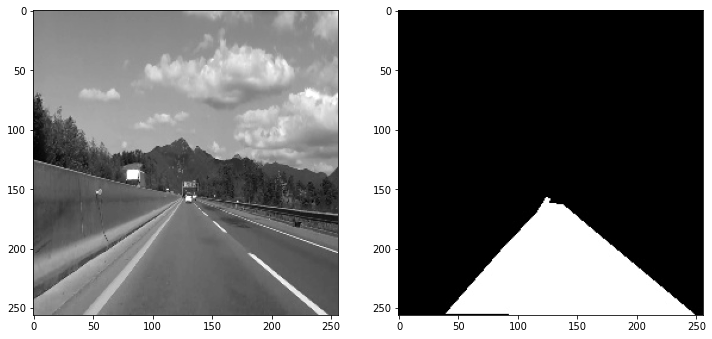

In [ ]:
#checking random images and their corresponding masks
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [ ]:
#defining function for convolution block of UNET architecture
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same", activation = 'relu')(input)
    x = Dropout(0.5)(x)  
  

    x = Conv2D(num_filters, 3, padding="same", activation = 'relu')(x)
    x = Dropout(0.3)(x)

    return x



#defining a function for encoding path of UNET architecture
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   


#defining a function for decoding path of UNET architecture
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)#upscaling layer
    x = Concatenate()([x, skip_features])#for concatenating inputs from x and skip_features to be fed in next layer
    x = conv_block(x, num_filters)
    return x

In [ ]:
#Building UNET Architecture
inputs = Input((256,256,1))

s1, p1 = encoder_block(inputs, 64)
s2, p2 = encoder_block(p1, 128)
s3, p3 = encoder_block(p2, 256)
s4, p4 = encoder_block(p3, 512)

b1 = conv_block(p4, 1024) 

d1 = decoder_block(b1, s4, 512)
d2 = decoder_block(d1, s3, 256)
d3 = decoder_block(d2, s2, 128)
d4 = decoder_block(d3, s1, 64)

outputs = Conv2D(1, 1, padding="same", activation='sigmoid')(d4)

model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 256, 256, 64  640         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_27 (Dropout)           (None, 256, 256, 64  0           ['conv2d_76[0][0]']              
                                )                                                           

In [ ]:
#training the model for 25 epochs
history = model.fit(X_train, y_train,
                    batch_size=16,  
                    epochs=25, 
                    validation_data=(X_val, y_val), 
                    shuffle=False
)

Epoch 1/25
25/25 [==============================] - 74s 1s/step - loss: 0.9857 - accuracy: 0.8337 - val_loss: 0.4784 - val_accuracy: 0.8342
Epoch 2/25
25/25 [==============================] - 26s 1s/step - loss: 0.4552 - accuracy: 0.8348 - val_loss: 0.4287 - val_accuracy: 0.8342
Epoch 3/25
25/25 [==============================] - 26s 1s/step - loss: 0.4216 - accuracy: 0.8348 - val_loss: 0.4004 - val_accuracy: 0.8342
Epoch 4/25
25/25 [==============================] - 26s 1s/step - loss: 0.3423 - accuracy: 0.8348 - val_loss: 0.3398 - val_accuracy: 0.8342
Epoch 5/25
25/25 [==============================] - 24s 983ms/step - loss: 0.1925 - accuracy: 0.9021 - val_loss: 0.2568 - val_accuracy: 0.9268
Epoch 6/25
25/25 [==============================] - 26s 1s/step - loss: 0.1063 - accuracy: 0.9480 - val_loss: 0.1493 - val_accuracy: 0.9450
Epoch 7/25
25/25 [==============================] - 26s 1s/step - loss: 0.0867 - accuracy: 0.9569 - val_loss: 0.1556 - val_accuracy: 0.9292
Epoch 8/25
25/25 

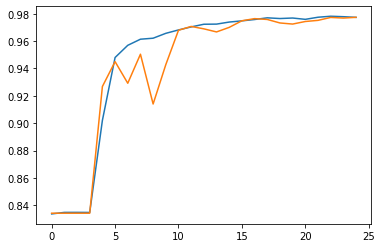

In [ ]:
#plotting training vs validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

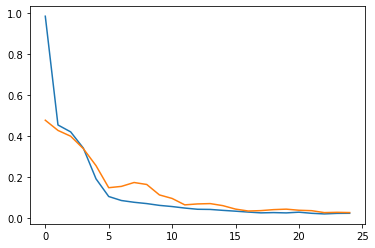

In [ ]:
#plotting training vs validation loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

(1, 256, 256, 1)
(256, 256)


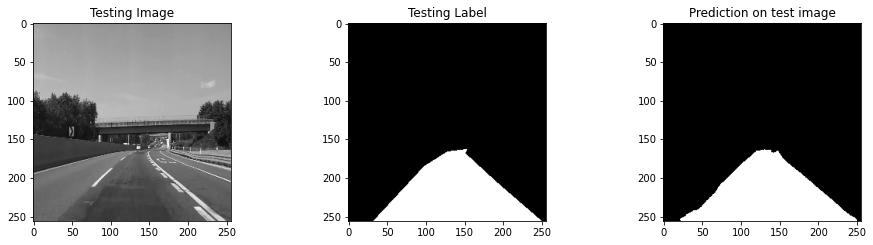

In [ ]:
#taking random samples from test set and ploting their masks along with predicted masks from the model
test_img_number = random.randint(0, len(X_test)-1)

test_img = X_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)

ground_truth = y_test[test_img_number]


prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)


plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')


plt.show()

In [ ]:
#saving model in my drive
model.save('/content/drive/MyDrive/data/unet_lane_97(2).h5')

In [ ]:
#evaluating performance of model on test set
model.evaluate(X_test, y_test)

2/2 [==============================] - 7s 6s/step - loss: 0.0331 - accuracy: 0.9762


[0.03309065103530884, 0.9761949181556702]